## Import librairies

In [1]:
import pandas as pd
import random
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
# to install pytorch, follow instructions on https://pytorch.org/get-started/locally/
# if CUDA is installed, this should allow GPU training
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
# -> pip install torchsummary
from torchsummary import summary
print(torch.cuda.is_available())

True


## Import data

In [2]:
df = pd.read_csv('Chess_Data.csv')

In [3]:
df

,images,category
0,Chess_Data\case_vide\square_00.png,--
1,Chess_Data\case_vide\square_01.png,--
2,Chess_Data\case_vide\square_02.png,--
3,Chess_Data\case_vide\square_03.png,--
4,Chess_Data\case_vide\square_04.png,--
...,...,...
827,Chess_Data\tour_noir\square_59.png,BR
828,Chess_Data\tour_noir\square_60.png,BR
829,Chess_Data\tour_noir\square_61.png,BR
830,Chess_Data\tour_noir\square_62.png,BR


In [4]:
df['category']

0      --
1      --
2      --
3      --
4      --
       ..
827    BR
828    BR
829    BR
830    BR
831    BR
Name: category, Length: 832, dtype: object

In [5]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['category'])
y = le.transform(df['category'])
print(y)
print(y.shape)
print(list(le.inverse_transform(range(13))))

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  7  7  7  7  7  7  7  7  7

In [6]:
X = []
index = 0

for files in df.images: 
    X.append(cv2.cvtColor(cv2.imread(files), cv2.COLOR_BGR2RGB))
    index = index+1

X = np.asarray(X)
print(X.shape)

(832, 128, 128, 3)


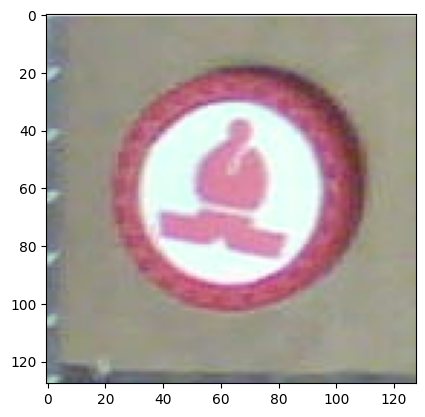

In [7]:
e = random.randint(0, len(X))
plt.imshow(X[e])

## Split into train and test

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)
#print(X_train.shape)
#print(y_train.shape)
#print(X_test.shape)
#print(y_test.shape)

X_train = X
Y_train = y
print(X_train.shape)
X_train = np.repeat(X_train, 10, axis=0)
print(X_test.shape)
print(Y_train.shape)
Y_train = np.repeat(Y_train, 10, axis=0)
print(Y_train.shape)

(832, 128, 128, 3)
(167, 128, 128, 3)
(832,)
(167,)


In [ ]:
# Define a set of data augmentation transformations
transform = transforms.Compose([
    transforms.RandomRotation(5, fill=(0, 0, 0)),  # Random rotation with blue border
    transforms.RandomAffine(0, translate=(0.05, 0.05), fill=(0, 0, 0)),  # Random shifts with blue border
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Random brightness adjustment
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5)),  # Random Gaussian blur
    transforms.ToTensor()  # Convert image to tensor
])

# Apply the transformations to the training dataset
class AugmentedDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx].astype('uint8'))
        label = self.labels[idx]
        image_resize = Image.fromarray(cv2.resize(np.array(image), (128, 128), interpolation=cv2.INTER_LINEAR))
        
        #rgb = image_resize.getpixel((0, 0))
        
        if self.transform:
            image_resize = self.transform(image_resize)

        
        return image_resize, label

# Create the augmented dataset
augmented_dataset = AugmentedDataset(X_train, Y_train, transform=transform)

# Create a DataLoader for the augmented dataset
augmented_loader = DataLoader(augmented_dataset, batch_size=10, shuffle=True)

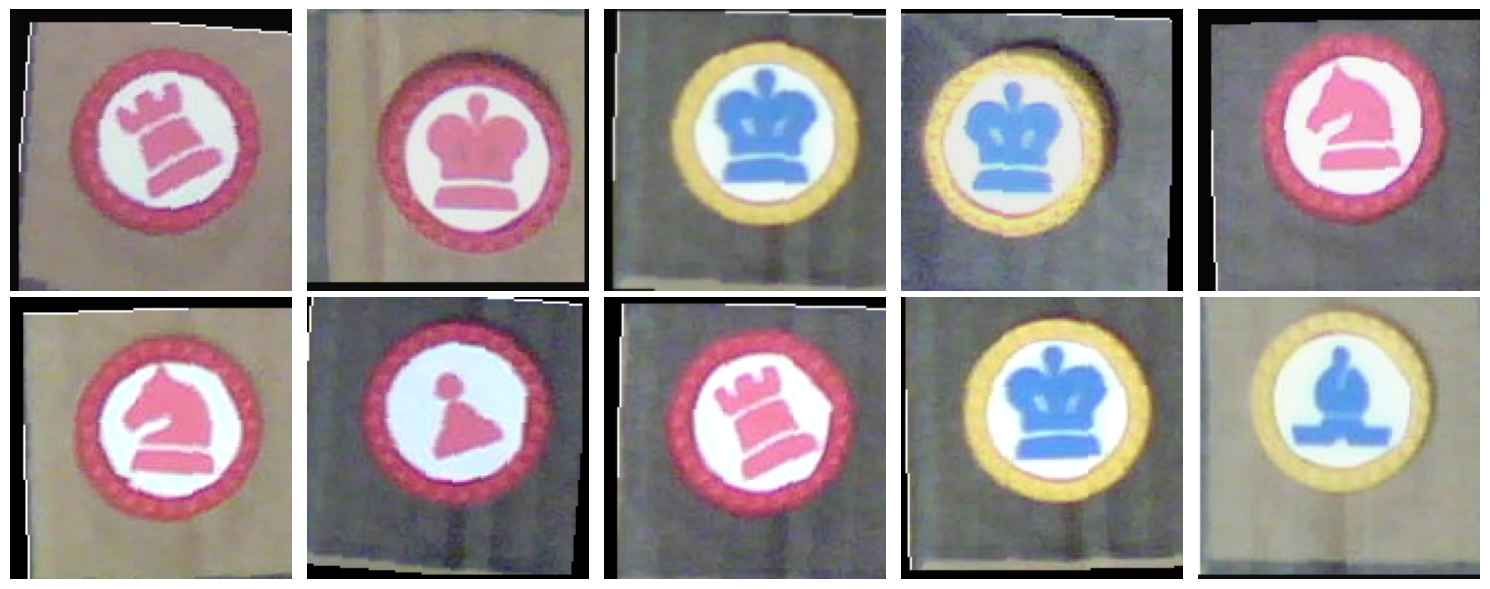

In [31]:
# Generate a batch of augmented images
augmented_images, _= next(iter(augmented_loader))

# Convert the images to numpy format for visualization
augmented_images = augmented_images.permute(0, 2, 3, 1).numpy()

# Create a grid to display the images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# Display each image in the grid
for img, ax in zip(augmented_images, axes):
    ax.imshow(img)
    ax.axis('off')  # Hide axes

plt.tight_layout()
plt.show()

## Build the model

In [32]:
#Model V3

class Magnus(nn.Module):
    def __init__(self):
        super(Magnus, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.15)
        # Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.20)
        # Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.25)
        # Classifier
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.dropout4 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 13)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        return x
    
# Instantiate the model, use the GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Magnus().to(device)

# Test with one batch
images, labels = next(iter(augmented_loader))
images = images.to(device)
outputs = model(images)
print("Output shape:", outputs.shape)   
    

Output shape: torch.Size([10, 13])


In [248]:
#Model V2

# Improved Magnus model
class Magnus(nn.Module):
    def __init__(self):
        super(Magnus, self).__init__()
        # More filters for richer features
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.3)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.4)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 16 * 16, 256)  # For input 128x128
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 64)
        self.dropout5 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 13)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = F.relu(self.fc2(x))
        x = self.dropout5(x)
        x = self.fc3(x)
        return x

# Instantiate the model, use the GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Magnus().to(device)

# Test with one batch
images, labels = next(iter(augmented_loader))
images = images.to(device)
outputs = model(images)
print("Output shape:", outputs.shape)

Output shape: torch.Size([10, 13])


In [ ]:
# Model V1

class Magnus(nn.Module):
    def __init__(self):
        super(Magnus, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3)  # Input: (batch_size, 3, 100, 100), Output: (batch_size, 8, 98, 98)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (batch_size, 8, 49, 49)
        self.dropout1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)  # Input: (batch_size, 8, 49, 49), Output: (batch_size, 16, 47, 47)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (batch_size, 16, 23, 23)
        self.dropout2 = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)  # Input: (batch_size, 16, 23, 23), Output: (batch_size, 32, 21, 21)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (batch_size, 32, 10, 10)
        self.dropout3 = nn.Dropout(0.3)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(6272, 400)  # Adjust input size based on the output of the last pooling layer * 11, 400)  # Adjust input size based on the output of the last pooling layer
        self.dropout4 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(400, 400)
        self.dropout5 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(400, 13)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.dropout1(x)
        # print('Output shape of layer 1', x.shape)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.dropout2(x)
        # print('Output shape of layer 2', x.shape)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.dropout3(x)
        # print('Output shape of layer 3', x.shape)
        
        x = self.flatten(x)

        #print('Shape required to pass to Linear Layer', x.shape)

        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = F.relu(self.fc2(x))
        x = self.dropout5(x)
        x = self.fc3(x) # Return the raw logits
        return x

# Instantiate the model, use the GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Magnus().to(device)

# test with one batch, to see if the model works. enable the prints in the forward pass for size matching.
# Get one batch of images from the dataloader
images, labels = next(iter(augmented_loader))

# Move the images to the device (GPU/CPU)
images = images.to(device)

# Pass the batch of images through the model
outputs = model.forward(images)

# Print the output shape
print("Output shape:", outputs.shape)

Output shape: torch.Size([10, 13])


In [33]:


# Print the model summary
summary(model, input_size=(3, 128, 128))  # Adjust input size as per your dataset

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
         MaxPool2d-3           [-1, 32, 64, 64]               0
           Dropout-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 64, 64]             128
         MaxPool2d-7           [-1, 64, 32, 32]               0
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
      BatchNorm2d-10          [-1, 128, 32, 32]             256
        MaxPool2d-11          [-1, 128, 16, 16]               0
          Dropout-12          [-1, 128, 16, 16]               0
          Flatten-13                [-1, 32768]               0
           Linear-14                  [

## Train the model

In [51]:
%%time

batch_size = 256
epochs = 1000

loss_history = []
accuracy_history = []



#Cas ou on entraine le modèle actuel
#recreate the dataloader with the new batch size
augmented_loader = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)

#Cas ou on entraine le modèle enregistré
# Instantiate your model and optimizer as usual
#model = Magnus().to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ---- Load model weights and optimizer state (if you want) ----
#checkpoint_path = "./model/magnus_model.pth"
#model.load_state_dict(torch.load(checkpoint_path))  # Load model weights






# Define the training loop

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in augmented_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to the device (GPU/CPU)

        optimizer.zero_grad()  # Clear the gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(augmented_loader)
    epoch_accuracy = 100 * correct / total

    # Store the loss and accuracy for this epoch
    loss_history.append(epoch_loss)
    accuracy_history.append(epoch_accuracy)


    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}")



Epoch 1/1000, Loss: 0.1781, Accuracy: 94.19
Epoch 2/1000, Loss: 0.1496, Accuracy: 94.96
Epoch 3/1000, Loss: 0.1424, Accuracy: 95.36
Epoch 4/1000, Loss: 0.1574, Accuracy: 95.25
Epoch 5/1000, Loss: 0.1599, Accuracy: 94.53
Epoch 6/1000, Loss: 0.1581, Accuracy: 94.69
Epoch 7/1000, Loss: 0.1662, Accuracy: 94.84
Epoch 8/1000, Loss: 0.1564, Accuracy: 95.19
Epoch 9/1000, Loss: 0.1482, Accuracy: 95.10
Epoch 10/1000, Loss: 0.1478, Accuracy: 95.18
Epoch 11/1000, Loss: 0.1502, Accuracy: 94.86
Epoch 12/1000, Loss: 0.1315, Accuracy: 95.56
Epoch 13/1000, Loss: 0.1300, Accuracy: 95.85
Epoch 14/1000, Loss: 0.1361, Accuracy: 95.55
Epoch 15/1000, Loss: 0.1313, Accuracy: 95.67
Epoch 16/1000, Loss: 0.1379, Accuracy: 95.47
Epoch 17/1000, Loss: 0.1467, Accuracy: 95.25
Epoch 18/1000, Loss: 0.1392, Accuracy: 95.44
Epoch 19/1000, Loss: 0.1255, Accuracy: 95.71
Epoch 20/1000, Loss: 0.1306, Accuracy: 95.89
Epoch 21/1000, Loss: 0.1283, Accuracy: 95.56
Epoch 22/1000, Loss: 0.1268, Accuracy: 95.76
Epoch 23/1000, Loss

KeyboardInterrupt: 

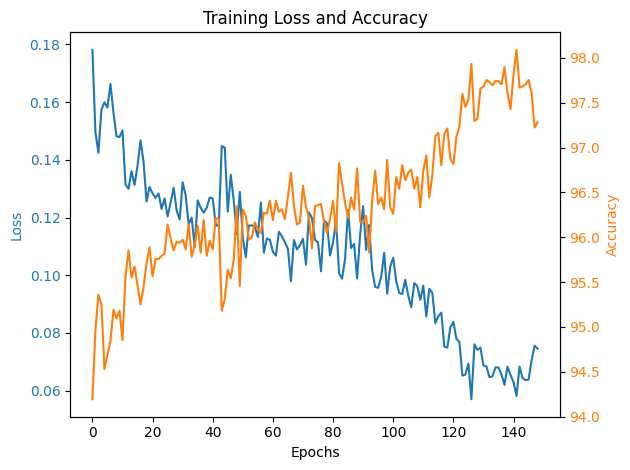

In [52]:
fig, ax1 = plt.subplots()

# Plot loss on the primary y-axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(loss_history, label='Loss', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:orange')
ax2.plot(accuracy_history, label='Accuracy', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add a title and show the plot
plt.title('Training Loss and Accuracy')
fig.tight_layout()
plt.show()

## Save and load the model and try with new data

In [55]:
# Save the PyTorch model
model_path = ".\\model\\magnus_model.pth"
torch.save(model.state_dict(), model_path)




# Evaluation

Test loss     : 0.0008
Test accuracy : 1.0000
              precision    recall  f1-score   support

          --       1.00      1.00      1.00        32
          BB       1.00      1.00      1.00         2
          BK       1.00      1.00      1.00         1
          BN       1.00      1.00      1.00         2
          BP       1.00      1.00      1.00         8
          BQ       1.00      1.00      1.00         1
          BR       1.00      1.00      1.00         2
          WB       1.00      1.00      1.00         2
          WK       1.00      1.00      1.00         1
          WN       1.00      1.00      1.00         2
          WP       1.00      1.00      1.00         8
          WQ       1.00      1.00      1.00         1
          WR       1.00      1.00      1.00         2

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64



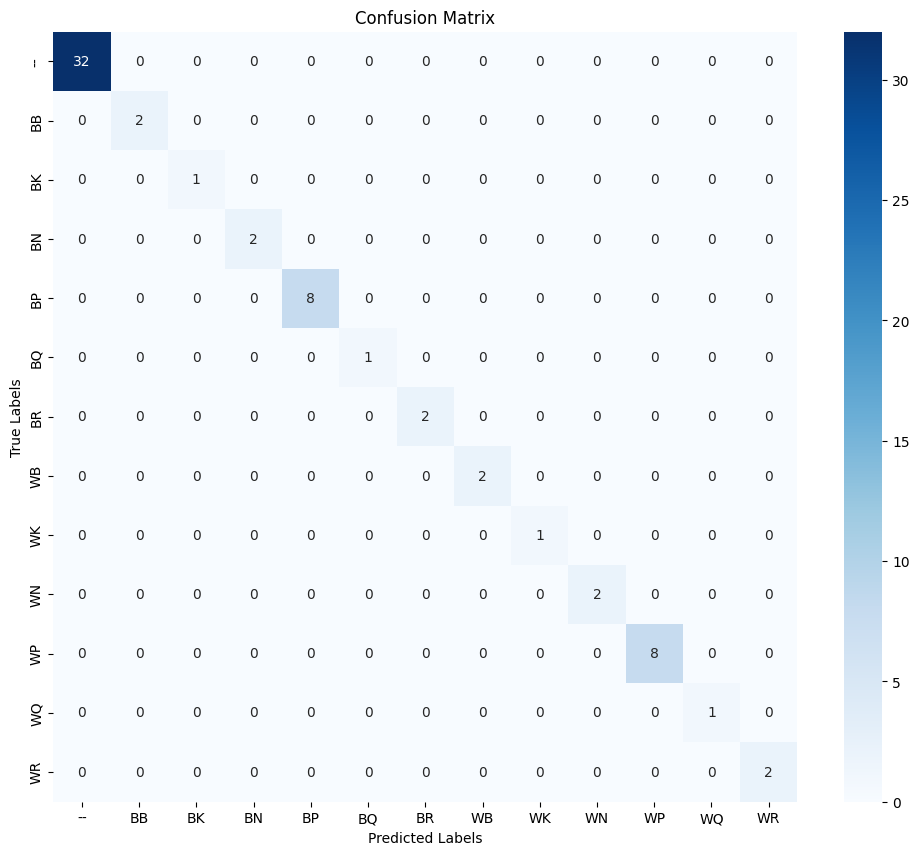

In [56]:
#Test with other images

# 1. Load the CSV with image paths and labels
df_test = pd.read_csv('Test_Data.csv')  # Make sure this file exists and is correct

# 2. Encode the labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df_test['category'])
y_test = le.transform(df_test['category'])

# 3. Load and preprocess images
X_test = [cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) for f in df_test['images']]
X_test = np.array([cv2.resize(img, (128, 128)) for img in X_test])
X_test = X_test / 255.0  # normalize

# 4. Convert to tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# 5. Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    y_pred = torch.argmax(outputs, dim=1).cpu().numpy()
    loss = criterion(outputs, y_test_tensor)
    accuracy = (y_pred == y_test).sum() / y_test.size

print(f'Test loss     : {loss.item():.4f}')
print(f'Test accuracy : {accuracy:.4f}')

# 6. Classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred, target_names=le.classes_))

import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()